In [3]:
import mmcv
import mmrotate
import mmdet
from mmcv.ops import get_compiling_cuda_version, get_compiler_version
# Check mmcv installation
print(mmcv.__version__) #noqa E1101
# Check MMRotate installation
print(mmrotate.__version__)
# Check MMDetection installation
print(mmdet.__version__)

print(get_compiling_cuda_version())
print(get_compiler_version())

2.0.0
1.0.0rc1
3.1.0
11.1
GCC 7.3


In [1]:
import torchvision
print(torchvision.__version__)
print(torchvision)

0.11.0+cu111
<module 'torchvision' from '/mnt/hdd/eric/.conda/envs/8.tmp/lib/python3.8/site-packages/torchvision/__init__.py'>


In [2]:
import torch
print(torch)

<module 'torch' from '/mnt/hdd/eric/.conda/envs/8.tmp/lib/python3.8/site-packages/torch/__init__.py'>


In [2]:
# We use mim to download the pre-trained checkpoints for inference and finetuning.
!mim download mmrotate --config rotated_rtmdet_tiny-3x-dota --dest .
!mim download mmrotate --config rotated_rtmdet_l-3x-dota --dest .

processing rotated_rtmdet_tiny-3x-dota...
rotated_rtmdet_tiny-3x-dota-9d821076.pth exists in /mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/06.Gits/01.SAMRS_MTP/MTP/MMRotate_1_x
Successfully dumped rotated_rtmdet_tiny-3x-dota.py to /mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/06.Gits/01.SAMRS_MTP/MTP/MMRotate_1_x
processing rotated_rtmdet_l-3x-dota...
rotated_rtmdet_l-3x-dota-23992372.pth exists in /mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/06.Gits/01.SAMRS_MTP/MTP/MMRotate_1_x
Successfully dumped rotated_rtmdet_l-3x-dota.py to /mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/06.Gits/01.SAMRS_MTP/MTP/MMRotate_1_x


In [3]:
from mmengine.config import Config
from mmengine.runner import Runner

from mmdet.utils import register_all_modules as register_all_modules_mmdet
from mmdet.apis import inference_detector, init_detector

from mmrotate.registry import VISUALIZERS
from mmrotate.utils import register_all_modules

# register all modules in mmdet into the registries
# do not init the default scope here because it will be init in the runner
register_all_modules_mmdet(init_default_scope=False)
register_all_modules(init_default_scope=False)

# Choose to use a config and initialize the detector
config = 'rotated_rtmdet_l-3x-dota.py'
# Setup a checkpoint file to load
checkpoint = 'rotated_rtmdet_l-3x-dota-23992372.pth'
# Set work_dir
work_dir = '../work_dirs/rotated_rtmdet_l-3x-dota'
# Set the device to be used for evaluation
device='cuda:0'
# Set inference path
img = './demo.jpg'

cfg = Config.fromfile(config)
cfg.load_from = checkpoint
cfg.work_dir = work_dir

# register all modules in mmrotate into the registries
register_all_modules()

# build the model from a config file and a checkpoint file
model = init_detector(cfg, checkpoint, palette="dota", device=device)
model

Loads checkpoint by local backend from path: rotated_rtmdet_l-3x-dota-23992372.pth


RTMDet(
  (data_preprocessor): DetDataPreprocessor()
  (backbone): CSPNeXt(
    (stem): Sequential(
      (0): ConvModule(
        (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): _BatchNormXd(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activate): SiLU(inplace=True)
      )
      (1): ConvModule(
        (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn): _BatchNormXd(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activate): SiLU(inplace=True)
      )
      (2): ConvModule(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn): _BatchNormXd(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activate): SiLU(inplace=True)
      )
    )
    (stage1): Sequential(
      (0): ConvModule(
        (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), pa

In [4]:
from mmrotate.registry import MODELS
from mmrotate.testing import get_detector_cfg
#from torchinfo import summary

cfg_file='../configs/rotated_rtmdet/rotated_rtmdet_l-3x-dota.py'
input_size=(1,3,1024,1024)
model=get_detector_cfg(cfg_file)
detector=MODELS.build(model)
#summary(detector, input_size)

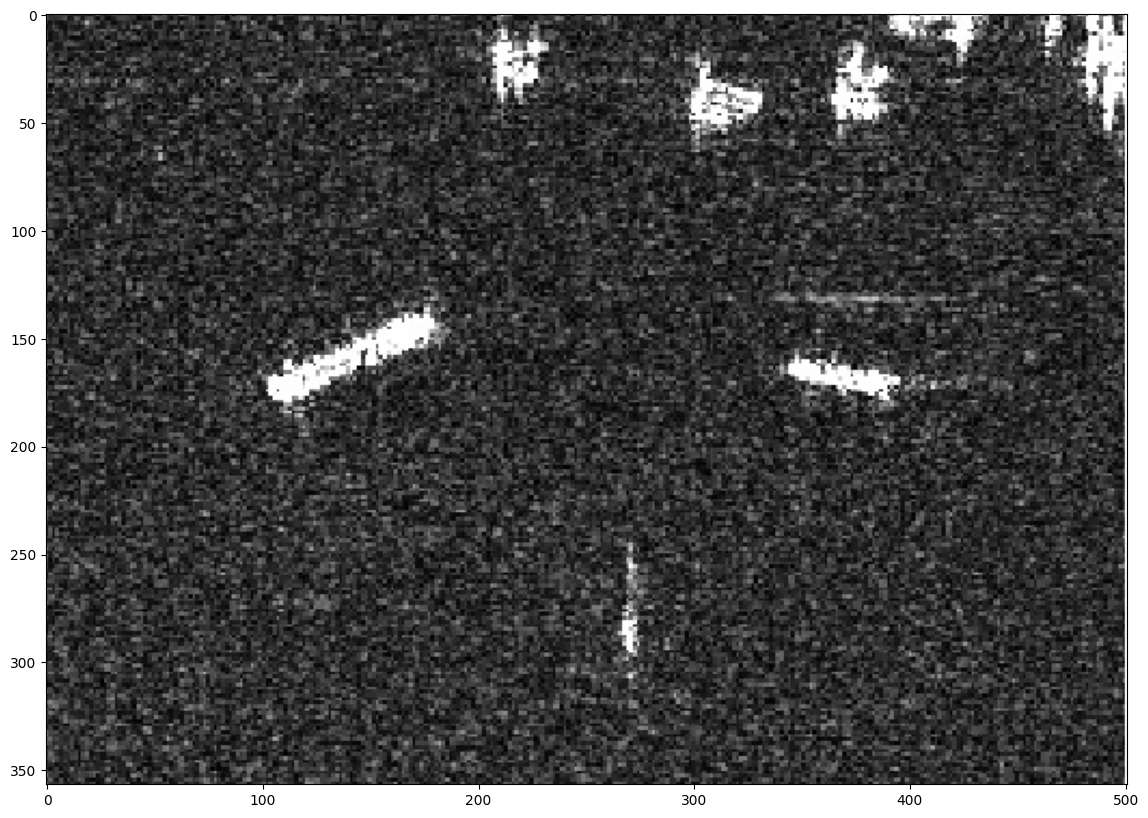

In [5]:
# Let's take a look at the dataset image
import matplotlib.pyplot as plt
img = mmcv.imread('ssdd_tiny/images/000631.png')
plt.figure(figsize=(15, 10))
plt.imshow(mmcv.bgr2rgb(img))
plt.show()

In [6]:
# Check the label of a single image
!cat ssdd_tiny/train/000631.txt

337 169 395 183 398 162 339 154 ship 0
263 273 261 296 276 297 279 272 ship 0
95 165 173 132 184 156 103 186 ship 0


In [7]:
from mmrotate.registry import DATASETS
from mmrotate.datasets.dota import DOTADataset

@DATASETS.register_module()
class TinyDataset(DOTADataset):
    """SAR ship dataset for detection."""
    
    METAINFO = {
            'classes':('ship',),
                # palette is a list of color tuples, which is used for visualization.
            'palette': [(165, 42, 42),]
        }

In [10]:
cfg = Config.fromfile('./rotated_rtmdet_tiny-3x-dota.py')

In [12]:
import random
import numpy as np
import torch


# Modify dataset type and path
cfg.data_root = 'ssdd_tiny/'
cfg.dataset_type = 'TinyDataset'

# modify num classes of the model in box head
cfg.model.bbox_head.num_classes = 1
# We can still use the pre-trained Mask RCNN model though we do not need to
# use the mask branch
cfg.load_from = 'rotated_rtmdet_tiny-3x-dota-9d821076.pth'

# Set up working dir to save files and logs.
cfg.work_dir = '../work_dirs/tutorial_exps'

cfg.optim_wrapper.optimizer.lr = 0.001

cfg.train_cfg.val_interval = 3
# Change the evaluation metric since we use customized dataset.
cfg.val_evaluator.metric = 'mAP'
# We can set the evaluation interval to reduce the evaluation times
cfg.val_evaluator.interval = 3
# We can set the checkpoint saving interval to reduce the storage cost
cfg.default_hooks.checkpoint.interval = 1
# cfg.max_epochs=36
cfg.train_cfg.max_epochs=cfg.max_epochs

# Set seed thus the results are more reproducible
cfg.seed = 0
random.seed(cfg.seed)
np.random.seed(cfg.seed)
torch.cuda.manual_seed(cfg.seed)
torch.cuda.manual_seed_all(cfg.seed)

cfg.gpu_ids = range(1)
cfg.device='cuda'


# modify pipeline mainly for resize scale (512,512)
cfg.train_pipeline = [
    dict(type='mmdet.LoadImageFromFile', backend_args=None),
    dict(type='mmdet.LoadAnnotations', with_bbox=True, box_type='qbox'),
    dict(type='ConvertBoxType', box_type_mapping=dict(gt_bboxes='rbox')),
    dict(type='mmdet.Resize', scale=(512, 512), keep_ratio=True),
    dict(
        type='mmdet.RandomFlip',
        prob=0.75,
        direction=['horizontal', 'vertical', 'diagonal']),
    dict(
        type='RandomRotate',
        prob=0.5,
        angle_range=180,
        rect_obj_labels=[9, 11]),
    dict(
        type='mmdet.Pad', size=(512, 512),
        pad_val=dict(img=(114, 114, 114))),
    dict(type='mmdet.PackDetInputs')
]
cfg.val_pipeline = [
    dict(type='mmdet.LoadImageFromFile', backend_args=None),
    dict(type='mmdet.Resize', scale=(512, 512), keep_ratio=True),
    dict(type='mmdet.LoadAnnotations', with_bbox=True, box_type='qbox'),
    dict(type='ConvertBoxType', box_type_mapping=dict(gt_bboxes='rbox')),
    dict(
        type='mmdet.Pad', size=(512, 512),
        pad_val=dict(img=(114, 114, 114))),
    dict(
        type='mmdet.PackDetInputs',
        meta_keys=('img_id', 'img_path', 'ori_shape', 'img_shape',
                   'scale_factor'))
]
cfg.test_pipeline = [
    dict(type='mmdet.LoadImageFromFile', backend_args=None),
    dict(type='mmdet.Resize', scale=(512, 512), keep_ratio=True),
    dict(
        type='mmdet.Pad', size=(512, 512),
        pad_val=dict(img=(114, 114, 114))),
    dict(
        type='mmdet.PackDetInputs',
        meta_keys=('img_id', 'img_path', 'ori_shape', 'img_shape',
                   'scale_factor'))
]


cfg.val_dataloader.dataset.type = cfg.dataset_type
cfg.val_dataloader.dataset.ann_file = 'val'
cfg.val_dataloader.dataset.data_prefix=dict(img_path='images', img='images')
# cfg.val_dataloader.dataset.img_prefix = 'images'
cfg.val_dataloader.dataset.data_root = 'ssdd_tiny/'

cfg.train_dataloader.dataset.type = cfg.dataset_type
cfg.train_dataloader.dataset.ann_file = 'train'
cfg.train_dataloader.dataset.data_prefix=dict(img_path='images', img='images')
# cfg.train_dataloader.dataset.img_prefix = 'images'
cfg.train_dataloader.dataset.data_root = 'ssdd_tiny/'

cfg.test_dataloader.dataset.type = cfg.dataset_type
cfg.test_dataloader.dataset.data_prefix=dict(img_path='images', img='images')
cfg.test_dataloader.dataset.ann_file = 'val'
# cfg.test_dataloader.dataset.img_prefix = 'images'
cfg.test_dataloader.dataset.data_root = 'ssdd_tiny/'

cfg.train_dataloader.dataset.pipeline=cfg.train_pipeline
cfg.val_dataloader.dataset.pipeline=cfg.val_pipeline
cfg.test_dataloader.dataset.pipeline=cfg.test_pipeline

cfg.val_evaluator = dict(type='DOTAMetric', metric='mAP')
cfg.test_evaluator = cfg.val_evaluator
# We can also use tensorboard to log the training process
#cfg.vis_backends=[dict(type='TensorboardVisBackend')]
#cfg.visualizer = dict(type='mmrotate.RotLocalVisualizer',vis_backends=vis_backends)

# We can initialize the logger for training and have a look
# at the final config used for training
cfg.dump('./tiny_cfg.py')
print(f'Config:\n{cfg.pretty_text}')

Config:
angle_version = 'le90'
backend_args = None
base_lr = 0.00025
checkpoint = 'https://download.openmmlab.com/mmdetection/v3.0/rtmdet/cspnext_rsb_pretrain/cspnext-tiny_imagenet_600e.pth'
custom_hooks = [
    dict(type='mmdet.NumClassCheckHook'),
    dict(
        ema_type='mmdet.ExpMomentumEMA',
        momentum=0.0002,
        priority=49,
        type='EMAHook',
        update_buffers=True),
]
data_root = 'ssdd_tiny/'
dataset_type = 'TinyDataset'
default_hooks = dict(
    checkpoint=dict(interval=1, max_keep_ckpts=3, type='CheckpointHook'),
    logger=dict(interval=50, type='LoggerHook'),
    param_scheduler=dict(type='ParamSchedulerHook'),
    sampler_seed=dict(type='DistSamplerSeedHook'),
    timer=dict(type='IterTimerHook'),
    visualization=dict(type='mmdet.DetVisualizationHook'))
default_scope = 'mmrotate'
device = 'cuda'
env_cfg = dict(
    cudnn_benchmark=False,
    dist_cfg=dict(backend='nccl'),
    mp_cfg=dict(mp_start_method='fork', opencv_num_threads=0))
gpu_ids = ran

In [13]:
# register all modules in mmdet into the registries
# do not init the default scope here because it will be init in the runner
register_all_modules_mmdet(init_default_scope=False)
register_all_modules(init_default_scope=False)

# register all modules in mmrotate into the registries
register_all_modules()

# build the model from a config file and a checkpoint file
model = init_detector(cfg, cfg.checkpoint, palette="ssdd", device=cfg.device)


runner = Runner.from_cfg(cfg)
runner.train()

Loads checkpoint by http backend from path: https://download.openmmlab.com/mmdetection/v3.0/rtmdet/cspnext_rsb_pretrain/cspnext-tiny_imagenet_600e.pth


Downloading: "https://download.openmmlab.com/mmdetection/v3.0/rtmdet/cspnext_rsb_pretrain/cspnext-tiny_imagenet_600e.pth" to /mnt/hdd/eric/.cache/torch/hub/checkpoints/cspnext-tiny_imagenet_600e.pth


The model and loaded state dict do not match exactly

unexpected key in source state_dict: head.fc.weight, head.fc.bias

missing keys in source state_dict: neck.reduce_layers.0.conv.weight, neck.reduce_layers.0.bn.weight, neck.reduce_layers.0.bn.bias, neck.reduce_layers.0.bn.running_mean, neck.reduce_layers.0.bn.running_var, neck.reduce_layers.1.conv.weight, neck.reduce_layers.1.bn.weight, neck.reduce_layers.1.bn.bias, neck.reduce_layers.1.bn.running_mean, neck.reduce_layers.1.bn.running_var, neck.top_down_blocks.0.main_conv.conv.weight, neck.top_down_blocks.0.main_conv.bn.weight, neck.top_down_blocks.0.main_conv.bn.bias, neck.top_down_blocks.0.main_conv.bn.running_mean, neck.top_down_blocks.0.main_conv.bn.running_var, neck.top_down_blocks.0.short_conv.conv.weight, neck.top_down_blocks.0.short_conv.bn.weight, neck.top_down_blocks.0.short_conv.bn.bias, neck.top_down_blocks.0.short_conv.bn.running_mean, neck.top_down_blocks.0.short_conv.bn.running_var, neck.top_down_blocks.0.final_conv.c

/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/06.Gits/01.SAMRS_MTP/MTP/MMRotate_1_x/mmrotate/mmrotate/structures/bbox/rotated_boxes.py:192: UserWarning: The `clip` function does nothing in `RotatedBoxes`.
  warnings.warn('The `clip` function does nothing in `RotatedBoxes`.')
/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/06.Gits/01.SAMRS_MTP/MTP/MMRotate_1_x/mmrotate/mmrotate/structures/bbox/rotated_boxes.py:192: UserWarning: The `clip` function does nothing in `RotatedBoxes`.
  warnings.warn('The `clip` function does nothing in `RotatedBoxes`.')
/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/06.Gits/01.SAMRS_MTP/MTP/MMRotate_1_x/mmrotate/mmrotate/structures/bbox/rotated_boxes.py:192: UserWarning: The `clip` function does nothing in `RotatedBoxes`.
  warnings.warn('The `clip` function does nothing in `RotatedBoxes`.')
/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/06.Gits/01.SAMRS_MTP/MTP/MMRotate_1_x/mmrotate/mmrotate/structures/bbox/rotated_boxes.py:192: UserWarning: The `clip` function does nothing in `Rotate

04/26 19:43:29 - mmengine - INFO - Exp name: rotated_rtmdet_tiny-3x-dota_20240426_194323
04/26 19:43:29 - mmengine - INFO - Epoch(train)  [1][14/14]  base_lr: 1.3023e-05 lr: 1.3023e-05  eta: 0:01:53  time: 0.2319  data_time: 0.0448  memory: 2314  loss: 2.4352  loss_cls: 1.6411  loss_bbox: 0.7941
04/26 19:43:29 - mmengine - INFO - Saving checkpoint at 1 epochs
04/26 19:43:32 - mmengine - INFO - Exp name: rotated_rtmdet_tiny-3x-dota_20240426_194323
04/26 19:43:32 - mmengine - INFO - Epoch(train)  [2][14/14]  base_lr: 2.7037e-05 lr: 2.7037e-05  eta: 0:01:31  time: 0.1921  data_time: 0.0308  memory: 2314  loss: 2.4400  loss_cls: 1.6530  loss_bbox: 0.7870
04/26 19:43:32 - mmengine - INFO - Saving checkpoint at 2 epochs
04/26 19:43:35 - mmengine - INFO - Exp name: rotated_rtmdet_tiny-3x-dota_20240426_194323
04/26 19:43:35 - mmengine - INFO - Epoch(train)  [3][14/14]  base_lr: 4.1051e-05 lr: 4.1051e-05  eta: 0:01:22  time: 0.1796  data_time: 0.0256  memory: 2314  loss: 2.4508  loss_cls: 1.676

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:14                                                                                   │
│                                                                                                  │
│   11                                                                                             │
│   12                                                                                             │
│   13 runner = Runner.from_cfg(cfg)                                                               │
│ ❱ 14 runner.train()                                                                              │
│   15                                                                                             │
│                                                                                                  │
│ /mnt/hdd/eric/.conda/envs/8.tmp/lib/python3.8/site-packages/mmengine/runner/runner.py:1777 in    │
│ train                                                                                            │
│                                                                                                  │
│   1774 │   │   # This must be called **AFTER** model has been wrapped.                           │
│   1775 │   │   self._maybe_compile('train_step')                                                 │
│   1776 │   │                                                                                     │
│ ❱ 1777 │   │   model = self.train_loop.run()  # type: ignore                                     │
│   1778 │   │   self.call_hook('after_run')                                                       │
│   1779 │   │   return model                                                                      │
│   1780                                                                                           │
│                                                                                                  │
│ /mnt/hdd/eric/.conda/envs/8.tmp/lib/python3.8/site-packages/mmengine/runner/loops.py:96 in run   │
│                                                                                                  │
│    93 │   │   self.runner.call_hook('before_train')                                              │
│    94 │   │                                                                                      │
│    95 │   │   while self._epoch < self._max_epochs and not self.stop_training:                   │
│ ❱  96 │   │   │   self.run_epoch()                                                               │
│    97 │   │   │                                                                                  │
│    98 │   │   │   self._decide_current_val_interval()                                            │
│    99 │   │   │   if (self.runner.val_loop is not None                                           │
│                                                                                                  │
│ /mnt/hdd/eric/.conda/envs/8.tmp/lib/python3.8/site-packages/mmengine/runner/loops.py:114 in      │
│ run_epoch                                                                                        │
│                                                                                                  │
│   111 │   │   for idx, data_batch in enumerate(self.dataloader):                                 │
│   112 │   │   │   self.run_iter(idx, data_batch)                                                 │
│   113 │   │                                                                                      │
│ ❱ 114 │   │   self.runner.call_hook('after_train_epoch')                                         │
│   115 │   │   self._epoch += 1                                                                   │
│   116 │                                                                                          │
│   117 │   def run_iter(self, idx, data_batch: Sequence[dict